# 🧬 CancerNet with Quick Mode & Full Mode (Keras 3.x Fix)
This notebook supports both quick testing and full dataset training.
It also fixes the `.h5` save issue by using the new `.keras` format.

## 📥 Step 0: Download Dataset from KaggleHub

In [1]:

import kagglehub
import os
from glob import glob

# Download dataset
path = kagglehub.dataset_download("paultimothymooney/breast-histopathology-images")
print("✅ Dataset downloaded to:", path)

# Base dataset path
src_path = os.path.join(path, "IDC_regular_ps50_idx5")

# Collect benign and malignant files recursively
files_0 = glob(os.path.join(src_path, "*", "0", "*.png"), recursive=True)
files_1 = glob(os.path.join(src_path, "*", "1", "*.png"), recursive=True)

print(f"Found {len(files_0)} benign and {len(files_1)} malignant images")


c:\Users\mycmo\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Dataset downloaded to: C:\Users\mycmo\.cache\kagglehub\datasets\paultimothymooney\breast-histopathology-images\versions\1
Found 198738 benign and 78786 malignant images


## ⚡ Step 1: Choose Mode (Quick vs Full)

In [2]:

# Set mode here: "quick" or "full"
MODE = "quick"   # change to "full" for entire dataset

if MODE == "quick":
    files_0 = files_0[:5000]  # subset benign
    files_1 = files_1[:5000]  # subset malignant
    print("⚡ Quick mode enabled: using 5k benign + 5k malignant images")
else:
    print("🏗 Full mode enabled: using all images")


⚡ Quick mode enabled: using 5k benign + 5k malignant images


## 📂 Step 2: Create Train/Val/Test Splits (No Copying, Faster)

In [3]:

import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Build dataframe
all_files = files_0 + files_1
labels = [0]*len(files_0) + [1]*len(files_1)
df = pd.DataFrame({"filename": all_files, "class": labels})

# Train/val/test split
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df["class"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["class"], random_state=42)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

# Data generators (no file copying required ✅)
datagen = ImageDataGenerator(rescale=1./255)
train_gen = datagen.flow_from_dataframe(train_df, x_col="filename", y_col="class", target_size=(50,50), class_mode="raw", batch_size=32)
val_gen   = datagen.flow_from_dataframe(val_df,   x_col="filename", y_col="class", target_size=(50,50), class_mode="raw", batch_size=32)
test_gen  = datagen.flow_from_dataframe(test_df,  x_col="filename", y_col="class", target_size=(50,50), class_mode="raw", batch_size=32)


Train: 7000, Val: 1500, Test: 1500
Found 7000 validated image filenames.
Found 1500 validated image filenames.
Found 1500 validated image filenames.


## 🏗 Step 3: Build CNN Model (CancerNet)

In [4]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(50,50,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


c:\Users\mycmo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 22, 22, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 7744)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       991,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,010,881 (3.86 MB)

 Trainable params: 1,010,881 (3.86 MB)

 Non-trainable params: 0 (0.00 B)

## 🎯 Step 4: Train the Model

In [5]:

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import os
os.makedirs("models", exist_ok=True)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint("models/cancernet.keras", save_best_only=True)  # ✅ fixed for Keras 3.x
]

history = model.fit(train_gen, validation_data=val_gen, epochs=5 if MODE=="quick" else 10, callbacks=callbacks)


Epoch 1/5


c:\Users\mycmo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


219/219 ━━━━━━━━━━━━━━━━━━━━ 113s 484ms/step - accuracy: 0.7297 - loss: 0.5376 - val_accuracy: 0.8307 - val_loss: 0.3961
Epoch 2/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 21s 94ms/step - accuracy: 0.8335 - loss: 0.3880 - val_accuracy: 0.7900 - val_loss: 0.4713
Epoch 3/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 19s 84ms/step - accuracy: 0.8381 - loss: 0.3802 - val_accuracy: 0.8247 - val_loss: 0.3643
Epoch 4/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 18s 83ms/step - accuracy: 0.8427 - loss: 0.3701 - val_accuracy: 0.8360 - val_loss: 0.3990
Epoch 5/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 18s 83ms/step - accuracy: 0.8455 - loss: 0.3447 - val_accuracy: 0.8413 - val_loss: 0.3433


## 📊 Step 5: Evaluate the Model

In [6]:

loss, acc = model.evaluate(test_gen)
print(f"✅ Test Accuracy: {acc:.4f}")


47/47 ━━━━━━━━━━━━━━━━━━━━ 18s 378ms/step - accuracy: 0.8589 - loss: 0.3124
✅ Test Accuracy: 0.8553


## 📈 Step 6: Classification Report & Confusion Matrix

47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step
              precision    recall  f1-score   support

           0       0.48      0.45      0.46       750
           1       0.48      0.51      0.49       750

    accuracy                           0.48      1500
   macro avg       0.48      0.48      0.48      1500
weighted avg       0.48      0.48      0.48      1500



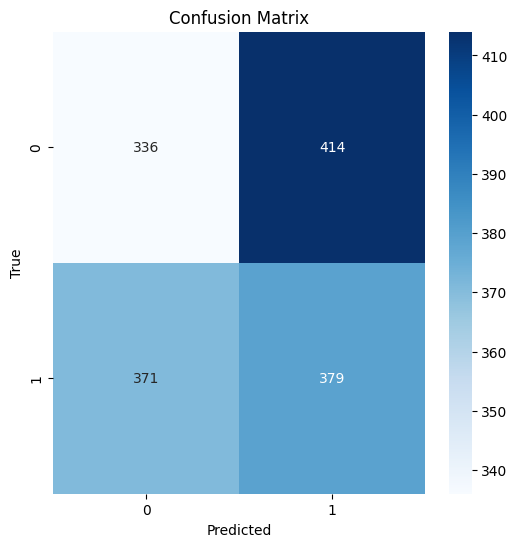

In [8]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predictions
y_pred = (model.predict(test_gen) > 0.5).astype("int32")

# True labels from generator
y_true = test_gen.labels  

# Classification report
print(classification_report(y_true, y_pred))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


## ✅ Step 7: Save Final Model

In [9]:

model.save("models/CancerNet_final.keras")  # ✅ fixed
print("Model saved successfully in Keras format!")


Model saved successfully in Keras format!
